In [1]:
import torchvision.models as models
import torch
from torch import nn, optim
from torchvision import transforms
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score
from help_func_torch.lion_pytorch import Lion
from help_func_torch.my_function import MyDataset, train_model, test_model, plot_history

In [2]:
weights = models.ViT_B_16_Weights.IMAGENET1K_V1
preprocess = weights.transforms(antialias=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
batch_size = 32
epochs = 15
patience = 5
path = 'dpl-project-1-dog-breed-identification/'

In [4]:
labels_data = pd.read_csv(path + 'labels.csv')
percent_split = np.array([0.8, 0.1, 0.1])
train_size, val_size, test_size = (percent_split * len(labels_data)).round().astype(np.int_).tolist()

train_df = labels_data.sample(train_size, random_state=42)

mask = list(set(labels_data.index) - set(train_df.index))
val_df = labels_data.iloc[mask].sample(val_size, random_state=42)

mask = list(set(labels_data.index) - set(train_df.index) - set(val_df.index))
test_df = labels_data.iloc[mask]

train_df = pd.concat([train_df, val_df])
val_df = test_df

print('train data:', len(train_df))
print('val data:', len(val_df))

train data: 9200
val data: 1022


In [5]:
data_augmentation = transforms.Compose([preprocess,
                                        transforms.RandomRotation(30),
                                        transforms.RandomHorizontalFlip(0.6),
                                        ])


train_data = MyDataset(directory=path + 'train/', subset=train_df, transform=data_augmentation)
val_data = MyDataset(directory=path + 'train/', subset=val_df, transform=preprocess)

In [6]:
labels_dict = train_data.labels_dict()
out_dims = len(labels_dict)

In [7]:
vit_b16 = models.vit_b_16(weights=weights)

for param in vit_b16.parameters():
    param.requires_grad = False

vit_b16.heads = nn.Sequential(nn.Dropout(0.5),
                              nn.Linear(768, out_dims))

vit_b16.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [8]:
trainable_params = sum(param.numel() for param in vit_b16.parameters() if param.requires_grad)
trainable_params

92280

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = Lion(params=[param for param in vit_b16.parameters() if param.requires_grad], lr=0.0001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [10]:
history, best, latest = train_model(model=vit_b16, criterion=criterion, 
                                    optimizer=optimizer, train=train_data, 
                                    val=val_data, batch_size=batch_size, 
                                    epochs=epochs, patience_threshold=patience, 
                                    scheduler=scheduler, device=device)

8 epoch(s): 100%|██████████| 288/288 [05:32<00:00,  1.15s/batch, train_loss: 0.1832 train_acc: 0.941 val_loss: 0.1668 val_acc: 0.945 learning_rate: 1e-07]


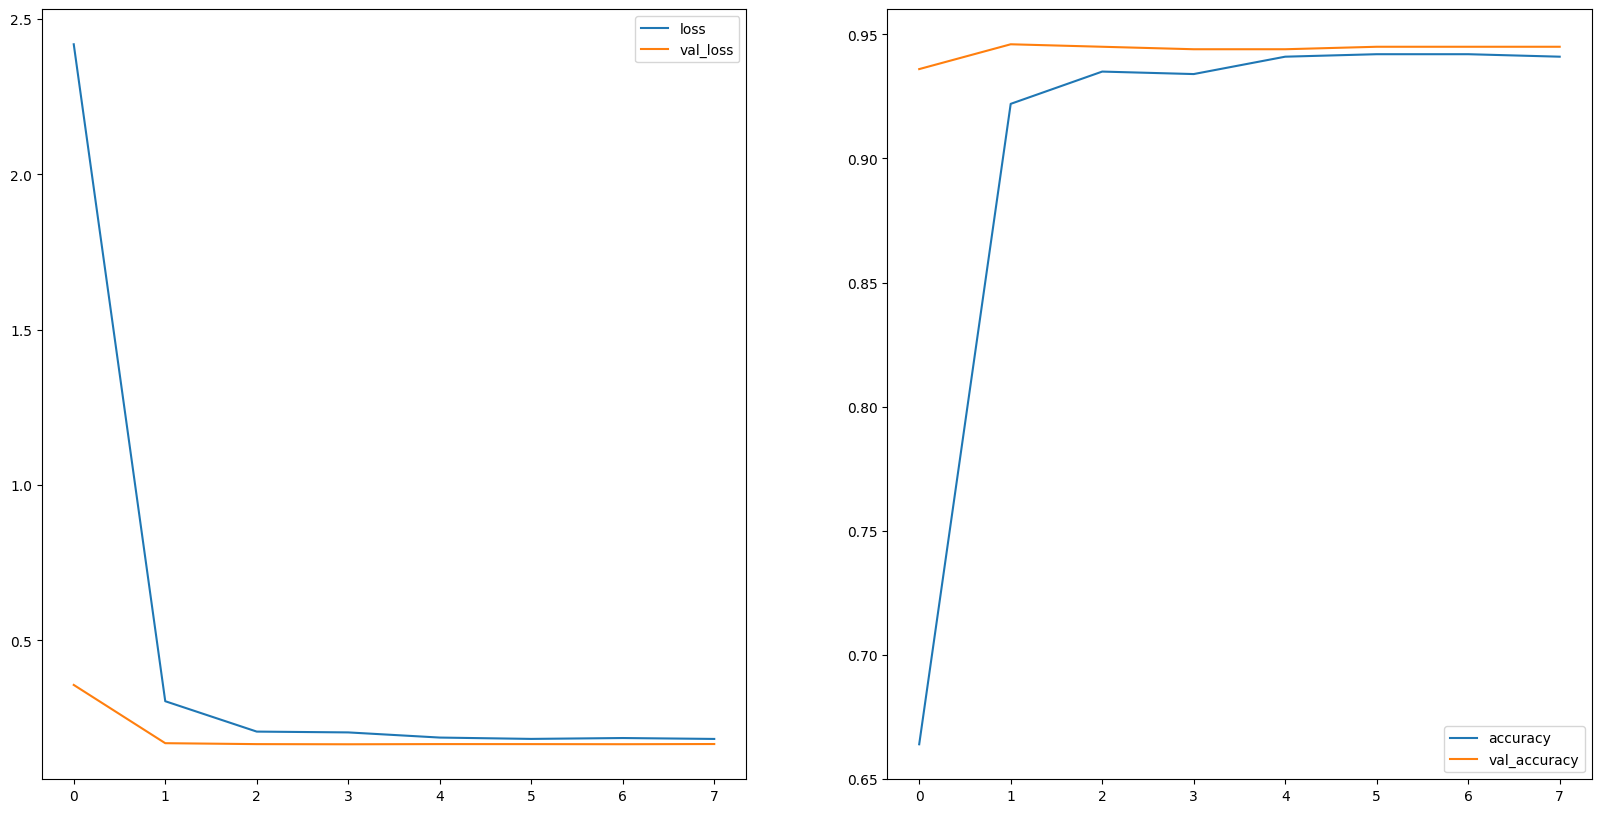

In [11]:
plot_history(history)

In [12]:
model_best = best['model']
optimizer_best = best['optimizer']
model_lastest = latest['model']
optimizer_latest = latest['optimizer']

torch.save({
            'model_best': model_best.state_dict(),
            'optimizer_best': optimizer_best.state_dict(),
            'model_latest': model_lastest.state_dict(),
            'optimizer_latest':optimizer_latest.state_dict()
            },'my_model_v2_final.pt')

In [13]:
y_true, y_pred, _ = test_model(model_lastest, test_data=val_data, device=device)

Time remain: 100%|██████████| 1022/1022 [00:34<00:00, 29.43it/s]


In [14]:
print(classification_report(y_true, y_pred))
print('accuracy:', accuracy_score(y_true, y_pred))
print('f1-score:', f1_score(y_true, y_pred, average='macro'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         6
           3       0.89      1.00      0.94         8
           4       0.78      0.88      0.82         8
           5       1.00      0.80      0.89         5
           6       0.89      1.00      0.94         8
           7       1.00      0.89      0.94         9
           8       1.00      1.00      1.00         9
           9       0.91      1.00      0.95        10
          10       1.00      1.00      1.00         8
          11       0.92      1.00      0.96        12
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        10
          14       0.88      1.00      0.93         7
          15       0.88      1.00      0.93         7
          16       0.77      1.00      0.87        10
          17       1.00    